In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import itertools
import bentoml

In [2]:
data_dir = '../data'

for file in os.listdir(data_dir):
    if file.endswith('.zip'):
        zip_path = os.path.join(data_dir, file)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
            print(f'Extracted {file}')


Extracted house-prices-advanced-regression-techniques.zip


In [3]:
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))


In [4]:
print("\nDataset Info")
print("\nTraining set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("\nTraining set info:")
print(train_df.info())


Dataset Info

Training set shape: (1460, 81)
Test set shape: (1459, 80)

Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  Hou

In [5]:
print("\n Numerical Features Summary")
print(train_df.describe())


 Numerical Features Summary
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407 

In [6]:

print("\n Missing Values Analysis")
missing_train = train_df.isnull().sum().sort_values(ascending=False)
missing_train_pct = (missing_train / len(train_df)) * 100
missing_summary = pd.DataFrame({
    'Missing Count': missing_train,
    'Missing Percentage': missing_train_pct
})
print(missing_summary[missing_summary['Missing Count'] > 0])


 Missing Values Analysis
              Missing Count  Missing Percentage
PoolQC                 1453           99.520548
MiscFeature            1406           96.301370
Alley                  1369           93.767123
Fence                  1179           80.753425
MasVnrType              872           59.726027
FireplaceQu             690           47.260274
LotFrontage             259           17.739726
GarageQual               81            5.547945
GarageFinish             81            5.547945
GarageYrBlt              81            5.547945
GarageType               81            5.547945
GarageCond               81            5.547945
BsmtExposure             38            2.602740
BsmtFinType2             38            2.602740
BsmtFinType1             37            2.534247
BsmtQual                 37            2.534247
BsmtCond                 37            2.534247
MasVnrArea                8            0.547945
Electrical                1            0.068493



 Missing Values Strategy
Based on the analysis, we'll handle missing values as follows:

Features to consider dropping (>80% missing):
['PoolQC', 'MiscFeature', 'Alley', 'Fence']

Imputation strategy for notable features:
- PoolQC: Mode imputation
- MiscFeature: Mode imputation
- Alley: Mode imputation
- Fence: Mode imputation
- MasVnrType: Mode imputation
- FireplaceQu: Mode imputation
- LotFrontage: Median imputation
- GarageQual: Mode imputation
- GarageFinish: Mode imputation
- GarageYrBlt: Median imputation
- GarageType: Mode imputation
- GarageCond: Mode imputation
- BsmtExposure: Mode imputation
- BsmtFinType2: Mode imputation
- BsmtFinType1: Mode imputation
- BsmtQual: Mode imputation
- BsmtCond: Mode imputation
- MasVnrArea: Median imputation
- Electrical: Mode imputation


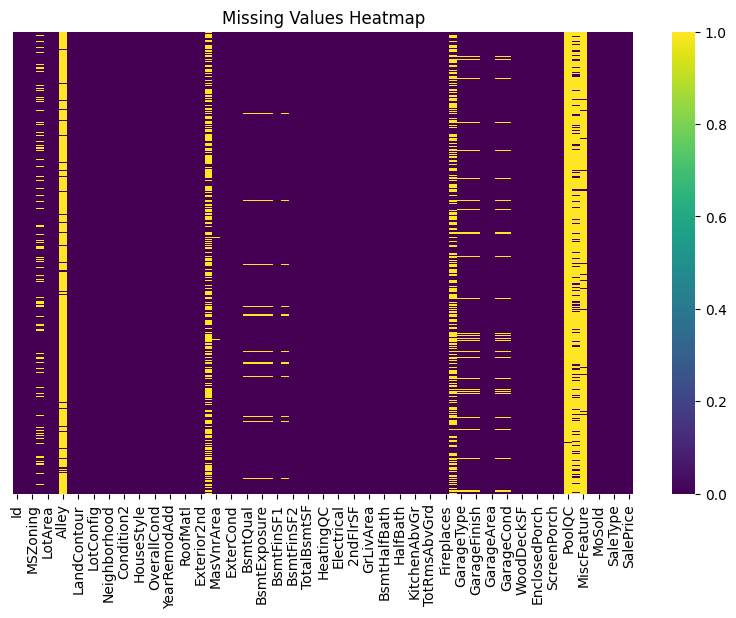

In [7]:

print("\n Missing Values Strategy")
print("Based on the analysis, we'll handle missing values as follows:")


high_missing = missing_summary[missing_summary['Missing Percentage'] > 80].index
print(f"\nFeatures to consider dropping (>80% missing):")
print(high_missing.tolist())


numerical_features = train_df.select_dtypes(include=[np.number]).columns
categorical_features = train_df.select_dtypes(include=['object']).columns

print("\nImputation strategy for notable features:")
for feature in missing_summary[missing_summary['Missing Count'] > 0].index:
    if feature in numerical_features:
        print(f"- {feature}: Median imputation")
    elif feature in categorical_features:
        print(f"- {feature}: Mode imputation")

plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


In [8]:
train_df = train_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])
print("\nDropped high-missing features")

# median imputation for numerical features
num_features = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
for feat in num_features:
    train_df = train_df.assign(**{feat: train_df[feat].fillna(train_df[feat].median())})

# mode imputation for categorical features
categorical_features = [
    'MasVnrType', 'FireplaceQu', 'GarageQual', 'GarageFinish',
    'GarageType', 'GarageCond', 'BsmtFinType2', 'BsmtExposure', 
    'BsmtCond', 'BsmtQual', 'BsmtFinType1', 'Electrical'
]
for feat in categorical_features:
    train_df = train_df.assign(**{feat: train_df[feat].fillna(train_df[feat].mode()[0])})
print("\nMode imputation complete")

print(f"\nMissing values remaining: {train_df.isnull().sum().sum()}")



Dropped high-missing features

Mode imputation complete

Missing values remaining: 0


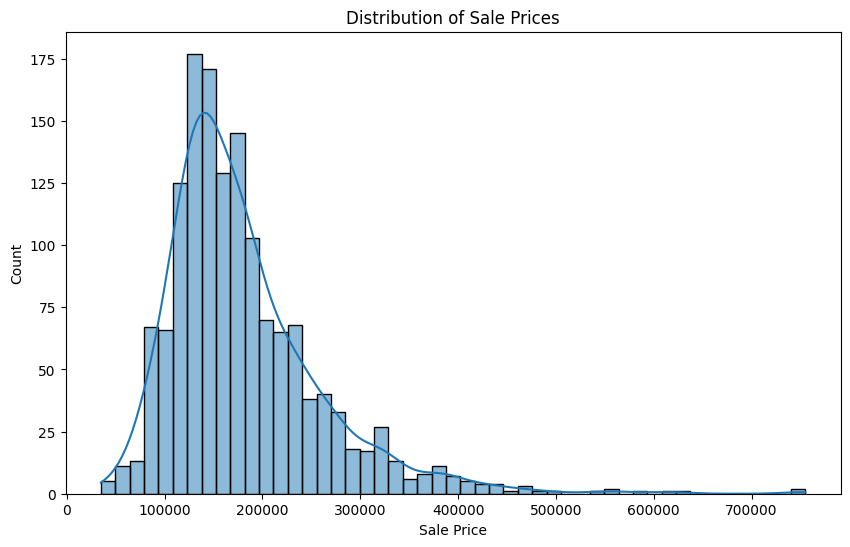

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.show()

In [10]:
print("\nSale Price Skewness:", stats.skew(train_df['SalePrice']))


Sale Price Skewness: 1.880940746034036


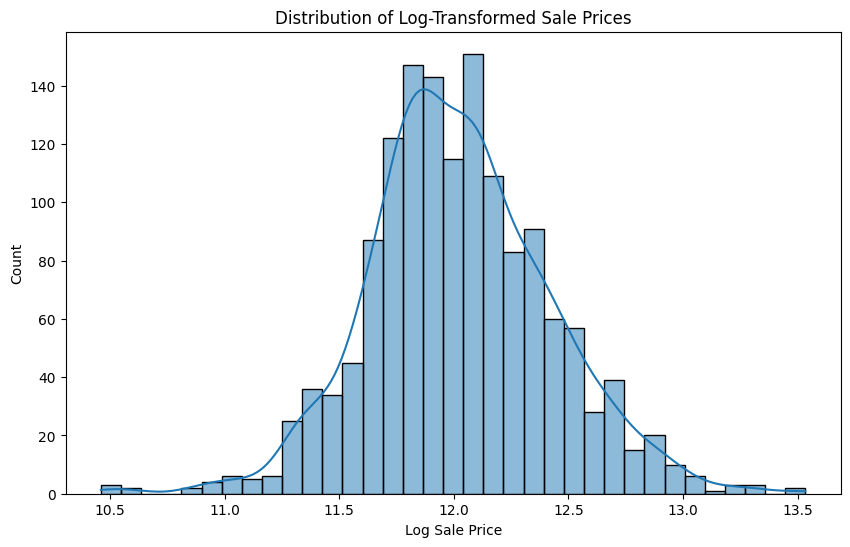

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(train_df['SalePrice']), kde=True)
plt.title('Distribution of Log-Transformed Sale Prices')
plt.xlabel('Log Sale Price')
plt.show()

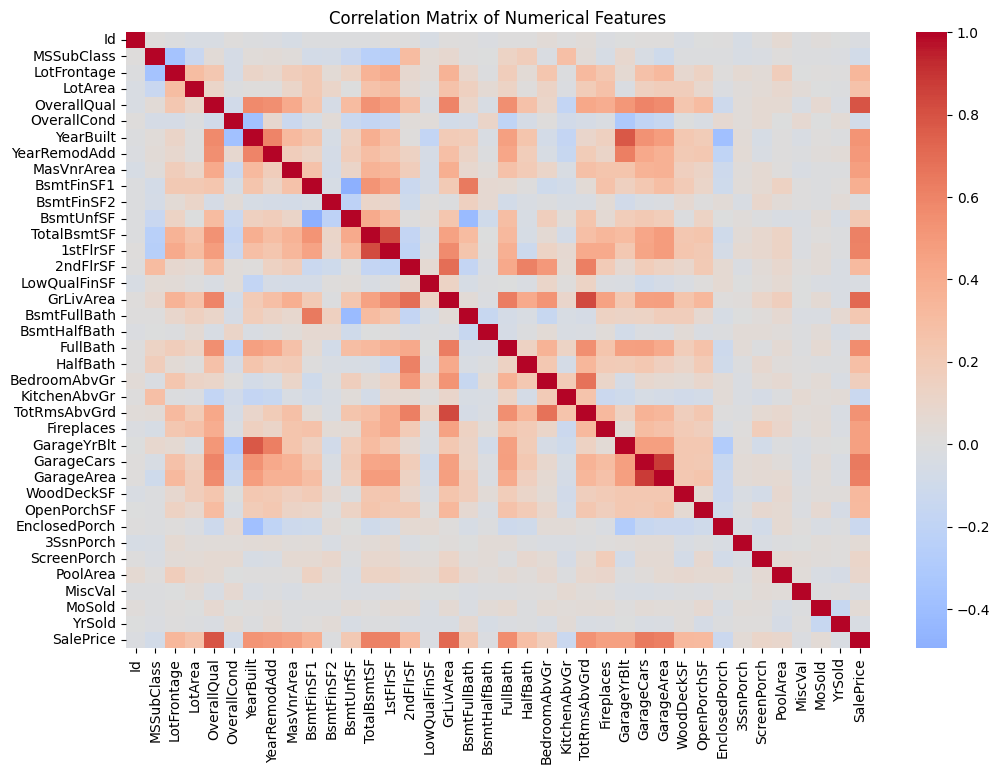

In [12]:
numerical_features = train_df.select_dtypes(include=[np.number]).columns
correlation_matrix = train_df[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [13]:
correlations = correlation_matrix['SalePrice'].sort_values(ascending=False)
print("\n Top 10 Correlations with Sale Price")
print(correlations[:10])


 Top 10 Correlations with Sale Price
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


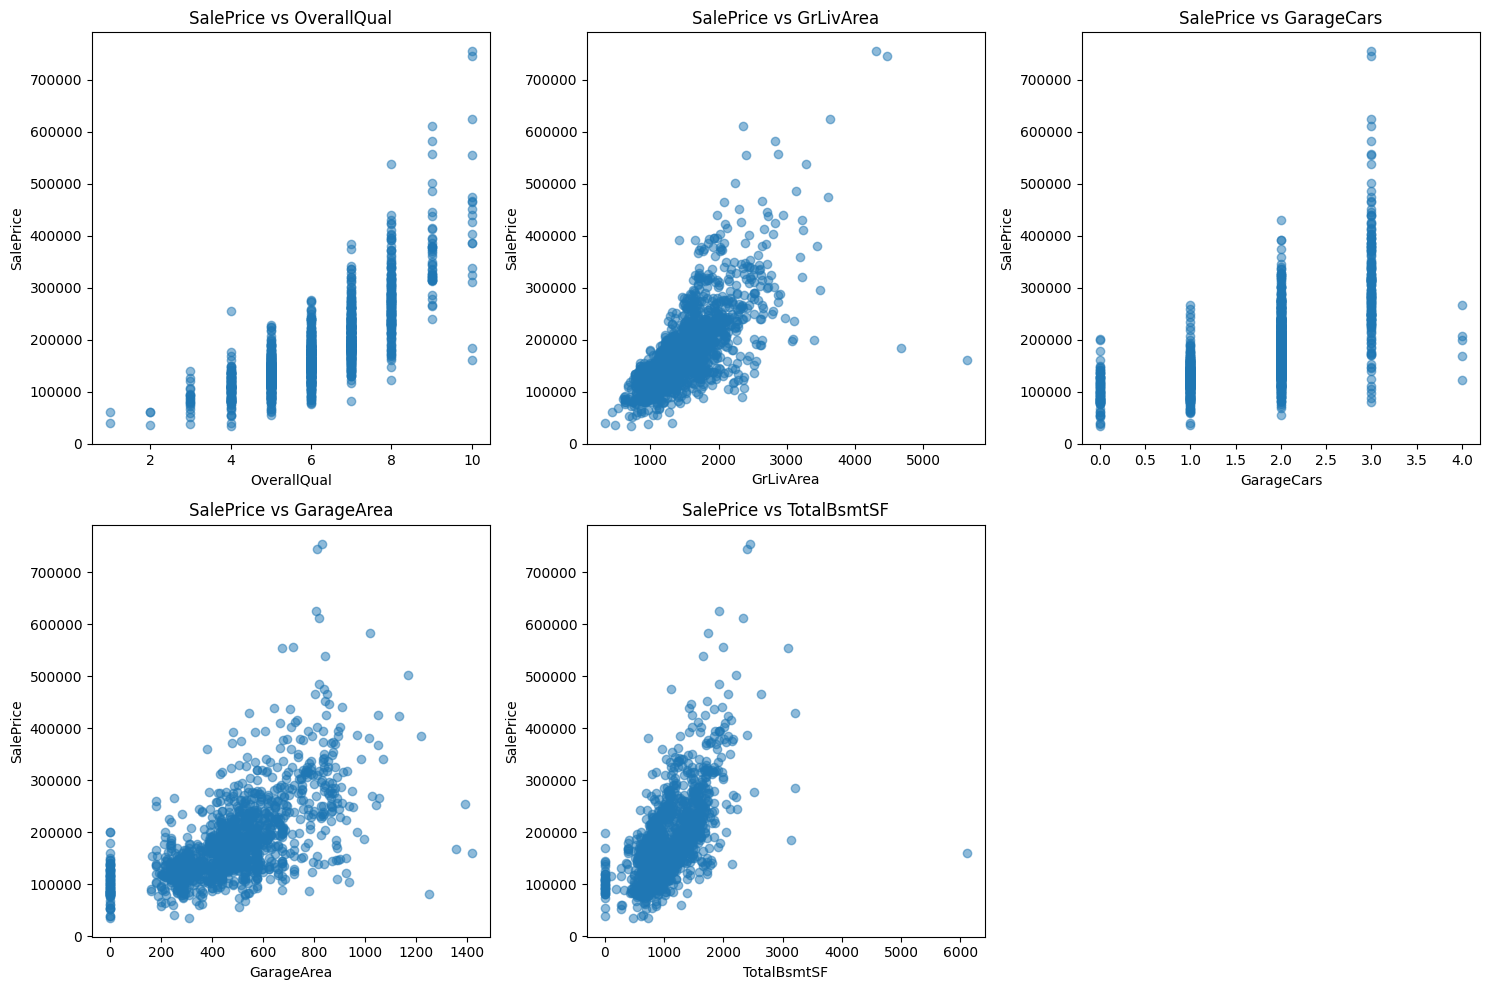

In [14]:
top_corr_features = correlations[1:6].index
plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_corr_features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(train_df[feature], train_df['SalePrice'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(f'SalePrice vs {feature}')
plt.tight_layout()
plt.show()

In [15]:
categorical_features = train_df.select_dtypes(include=['object']).columns
print("\n=== Categorical Features ===")
for feature in categorical_features:
    print(f"\nValue counts for {feature}:")
    print(train_df[feature].value_counts().head())


=== Categorical Features ===

Value counts for MSZoning:
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

Value counts for Street:
Street
Pave    1454
Grvl       6
Name: count, dtype: int64

Value counts for LotShape:
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64

Value counts for LandContour:
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64

Value counts for Utilities:
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

Value counts for LotConfig:
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64

Value counts for LandSlope:
LandSlope
Gtl    1382
Mod      65
Sev      13
Name: count, dtype: int64

Value counts for Neighborhood:
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Name: count, dtype: int64

Value counts for Condition1:
C

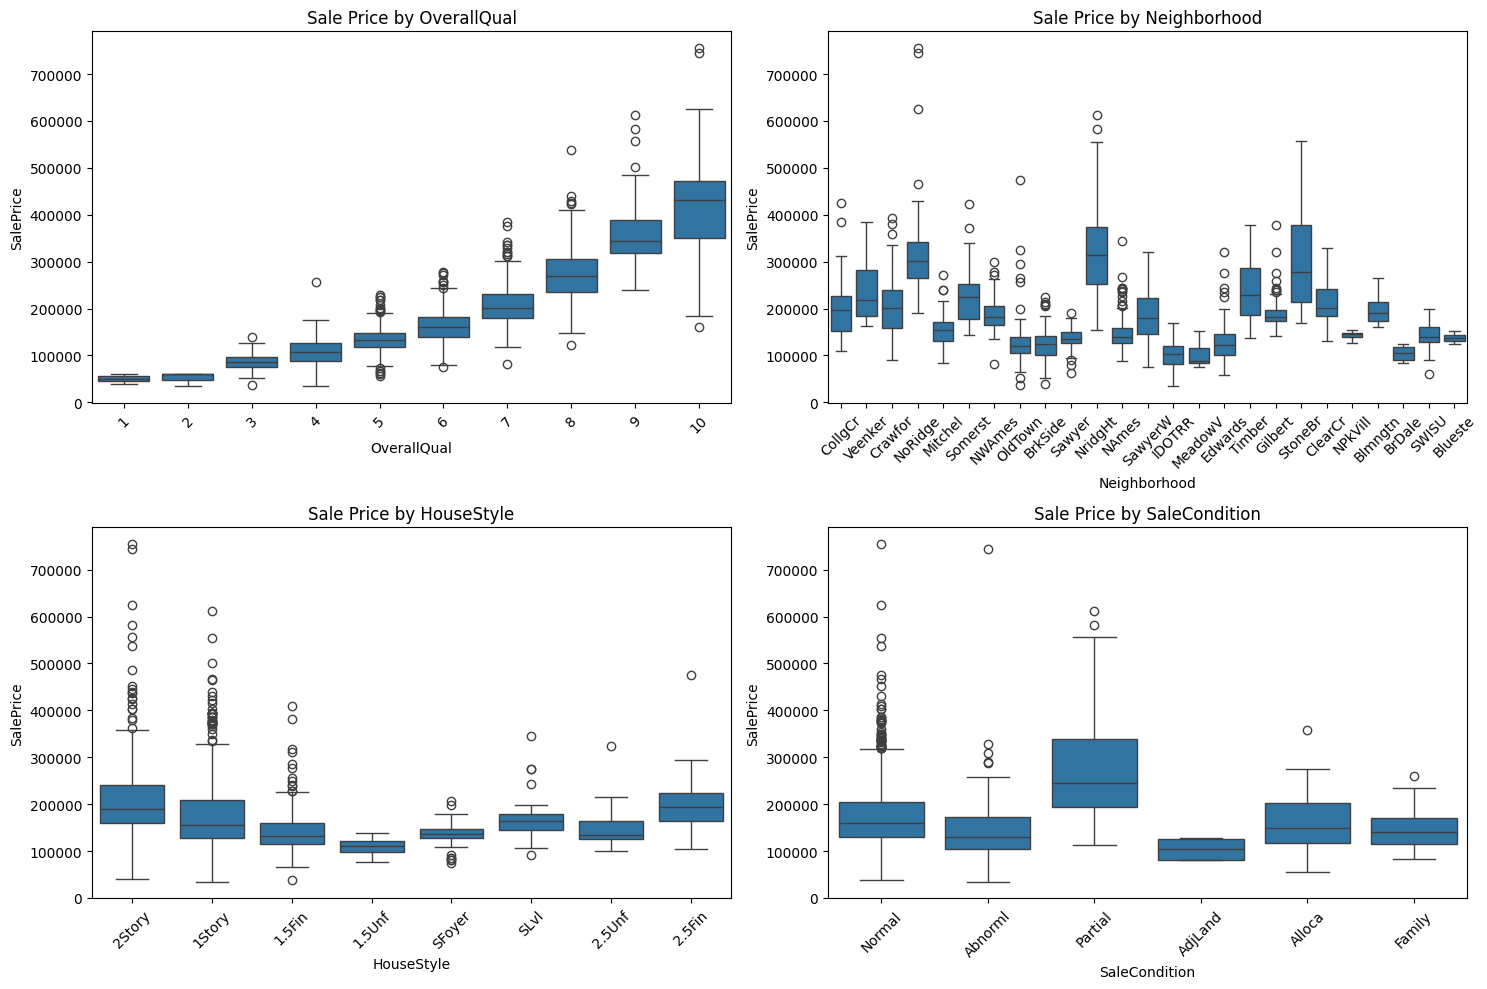

In [16]:
important_categorical = ['OverallQual', 'Neighborhood', 'HouseStyle', 'SaleCondition']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(important_categorical, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=feature, y='SalePrice', data=train_df)
    plt.xticks(rotation=45)
    plt.title(f'Sale Price by {feature}')
plt.tight_layout()
plt.show()

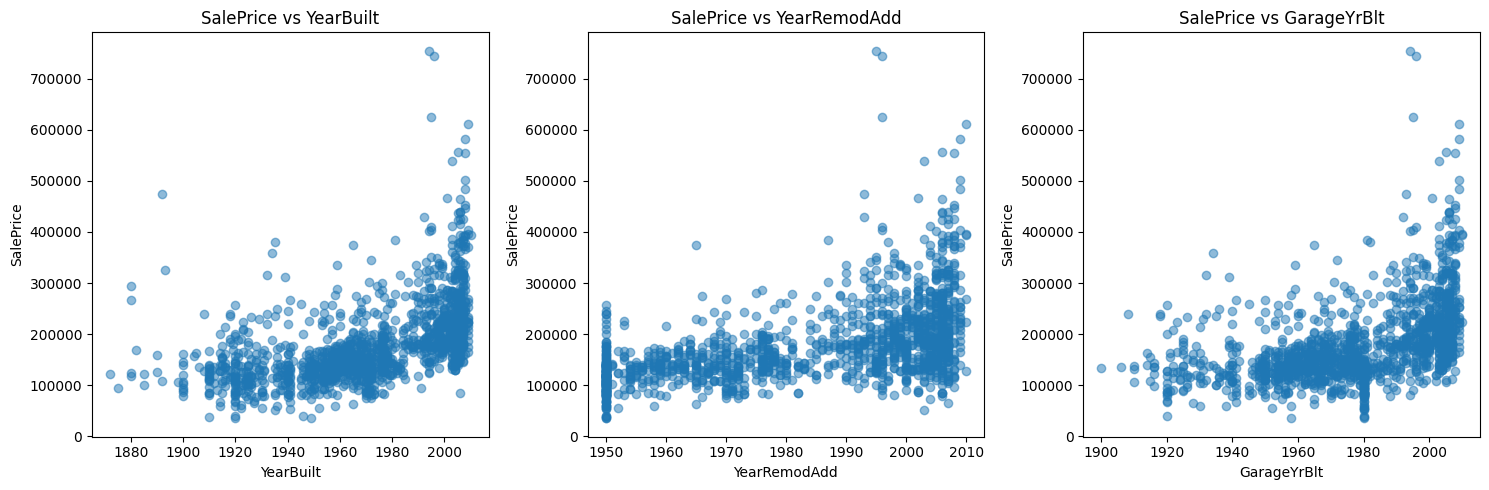

In [17]:
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(year_features, 1):
    plt.subplot(1, 3, i)
    plt.scatter(train_df[feature], train_df['SalePrice'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(f'SalePrice vs {feature}')
plt.tight_layout()
plt.show()


 Model Performance

Linear Regression:
RMSE: $33,616,133,312,544,388.00
R2 Score: -147326774424261191794688.0000
CV R2: -9814672315091359583174656.0000 (+/- 11026650120542420945862656.0000)

Ridge:
RMSE: $28,634.06
R2 Score: 0.8931
CV R2: 0.7789 (+/- 0.1668)


/home/mike/developer/house-pricing/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.124e+10, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(
/home/mike/developer/house-pricing/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.346e+10, tolerance: 5.453e+08
  model = cd_fast.enet_coordinate_descent(
/home/mike/developer/house-pricing/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the


Lasso:
RMSE: $28,500.90
R2 Score: 0.8941
CV R2: 0.7785 (+/- 0.1673)

Random Forest:
RMSE: $28,763.76
R2 Score: 0.8921
CV R2: 0.8432 (+/- 0.0822)

XGBoost:
RMSE: $26,654.08
R2 Score: 0.9074
CV R2: 0.8454 (+/- 0.0875)


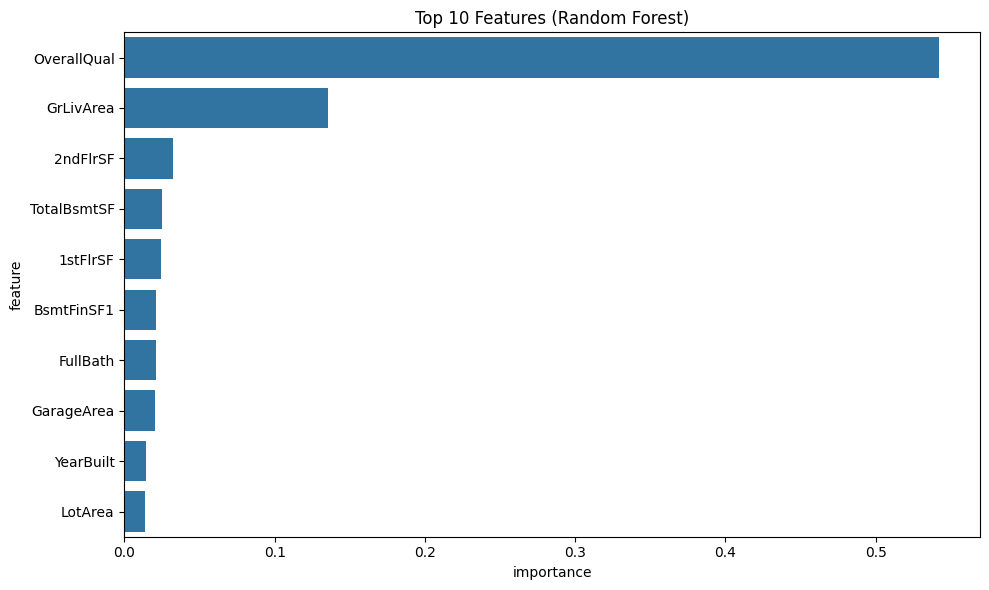

In [18]:

features = train_df.drop(['SalePrice', 'Id'], axis=1)
features = pd.get_dummies(features)
features = features.fillna(features.mean())

X = features
y = train_df['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

print("\n Model Performance")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    

    cv_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_cv_train = X_train_scaled[train_idx]
        y_cv_train = y_train.iloc[train_idx]
        X_cv_val = X_train_scaled[val_idx]
        y_cv_val = y_train.iloc[val_idx]
        
        model.fit(X_cv_train, y_cv_train)
        y_cv_pred = model.predict(X_cv_val)
        cv_scores.append(r2_score(y_cv_val, y_cv_pred))
    
    cv_scores = np.array(cv_scores)
    
    print(f"\n{name}:")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"CV R2: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


rf_model = models['Random Forest']
importance = pd.DataFrame({
    'feature': features.columns,
    'importance': rf_model.feature_importances_
}).nlargest(10, 'importance')

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance)
plt.title('Top 10 Features (Random Forest)')
plt.tight_layout()
plt.show()



New best RMSE: $30,860.01
Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0}

New best RMSE: $30,738.85
Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0}

New best RMSE: $30,701.01
Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0}
Progress: 10/128

New best RMSE: $29,284.63
Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0}

New best RMSE: $29,281.76
Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0}
Progress: 20/128
Progress: 30/128
Progress: 40/128
Progress: 50/128
Progress: 60/128

New bes

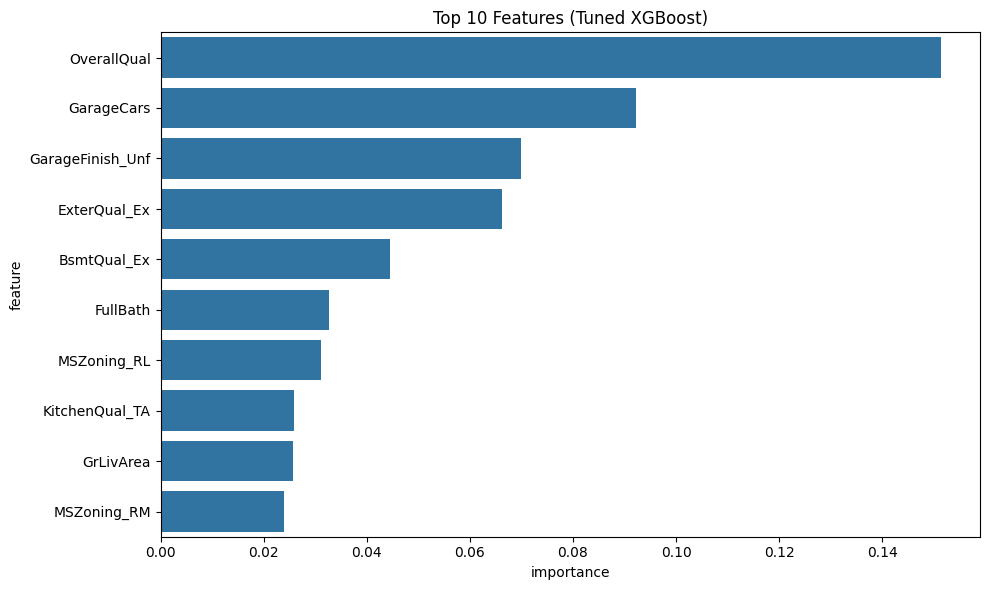

In [19]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)
best_score = float('inf')
best_params = None
total_iterations = np.prod([len(v) for v in param_grid.values()])
current_iteration = 0

# Grid search
for params in (dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())):
    cv_scores = []
    current_iteration += 1
    
    if current_iteration % 10 == 0:
        print(f"Progress: {current_iteration}/{total_iterations}")
    
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = XGBRegressor(**params, random_state=42)
        model.fit(X_cv_train, y_cv_train, eval_set=[(X_cv_val, y_cv_val)], verbose=False)
        
        y_cv_pred = model.predict(X_cv_val)
        cv_scores.append(np.sqrt(mean_squared_error(y_cv_val, y_cv_pred)))
    
    mean_rmse = np.mean(cv_scores)
    if mean_rmse < best_score:
        best_score = mean_rmse
        best_params = params
        print(f"\nNew best RMSE: ${mean_rmse:,.2f}")
        print(f"Parameters: {params}")

print(f"\nBest parameters: {best_params}")
print(f"Best RMSE: ${best_score:,.2f}")

# Train final model
best_xgb = XGBRegressor(**best_params, random_state=42)
best_xgb.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=False)

y_pred = best_xgb.predict(X_val_scaled)
final_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
final_r2 = r2_score(y_val, y_pred)

print(f"\nFinal model metrics:")
print(f"RMSE: ${final_rmse:,.2f}")
print(f"R2: {final_r2:.4f}")

# Feature importance
importance_df = pd.DataFrame({
    'feature': features.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("\nTop 10 features:")
for _, row in importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Top 10 Features (Tuned XGBoost)')
plt.tight_layout()
plt.show()


In [20]:
# Create simplified model with most important features
top_features = [
    'OverallQual',  # Quality rating
    'GrLivArea',    # Living area
    'GarageCars',   # Garage capacity 
    'GarageArea',   # Garage sq ft
    'TotalBsmtSF',  # Basement sq ft
    'FullBath',     # Full bathrooms
    'TotRmsAbvGrd', # Rooms above ground
    'YearBuilt'     # Construction year
]

# Get simplified feature matrices
X_train_simple = X_train[top_features]
X_val_simple = X_val[top_features]

# Create typical house profile using medians/modes
remaining_features = [col for col in X_train.columns if col not in top_features]
typical_house = pd.DataFrame(columns=X_train.columns)
typical_house.loc[0] = X_train.median()

# Handle categorical features
for col in remaining_features:
    if col.startswith(('MSZoning_', 'Street_', 'Alley_', 'LotShape_', 'LandContour_',
                      'Utilities_', 'LotConfig_', 'LandSlope_', 'Neighborhood_',
                      'Condition1_', 'Condition2_', 'BldgType_', 'HouseStyle_',
                      'RoofStyle_', 'RoofMatl_', 'Exterior1st_', 'Exterior2nd_',
                      'MasVnrType_', 'ExterQual_', 'ExterCond_', 'Foundation_',
                      'BsmtQual_', 'BsmtCond_', 'BsmtExposure_', 'BsmtFinType1_',
                      'BsmtFinType2_', 'Heating_', 'HeatingQC_', 'CentralAir_',
                      'Electrical_', 'KitchenQual_', 'Functional_', 'FireplaceQu_',
                      'GarageType_', 'GarageFinish_', 'GarageQual_', 'GarageCond_',
                      'PavedDrive_', 'SaleType_', 'SaleCondition_')):
        prefix = '_'.join(col.split('_')[:-1]) + '_'
        related_cols = [c for c in remaining_features if c.startswith(prefix)]
        typical_house.loc[0, related_cols] = 0
        most_common = X_train[related_cols].idxmax(axis=1).mode()[0]
        typical_house.loc[0, most_common] = 1

# Scale features
scaler_simple = StandardScaler()
X_train_simple_scaled = scaler_simple.fit_transform(X_train_simple)
X_val_simple_scaled = scaler_simple.transform(X_val_simple)

# Train simplified model
simple_params = {
    'learning_rate': 0.1,
    'max_depth': 4,
    'n_estimators': 300,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0
}

simple_xgb = XGBRegressor(**simple_params, random_state=42)
simple_xgb.fit(
    X_train_simple_scaled,
    y_train,
    eval_set=[(X_val_simple_scaled, y_val)],
    verbose=False
)

# Evaluate simplified model
y_pred_simple = simple_xgb.predict(X_val_simple_scaled)
simple_rmse = np.sqrt(mean_squared_error(y_val, y_pred_simple))
simple_r2 = r2_score(y_val, y_pred_simple)

print("Simplified model performance:")
print(f"RMSE: ${simple_rmse:,.2f}")
print(f"R2 Score: {simple_r2:.4f}")

print("\nModel comparison:")
print(f"Full RMSE: ${final_rmse:,.2f}")
print(f"Simple RMSE: ${simple_rmse:,.2f}")
print(f"Full R2: {final_r2:.4f}")
print(f"Simple R2: {simple_r2:.4f}")

# Save models
bentoml.xgboost.save_model('house-pricing-model-simple', simple_xgb)
bentoml.sklearn.save_model('house-price-scaler-simple', scaler_simple)


Simplified model performance:
RMSE: $30,651.55
R2 Score: 0.8775

Model comparison:
Full RMSE: $26,000.63
Simple RMSE: $30,651.55
Full R2: 0.9119
Simple R2: 0.8775


Model(tag="house-price-scaler-simple:lkdzzwwjvorblfqa", path="/home/mike/bentoml/models/house-price-scaler-simple/lkdzzwwjvorblfqa/")

In [21]:
bentoml.xgboost.save_model('house-pricing-model', best_xgb)

Model(tag="house-pricing-model:lkz2mgwjvov6dfqa", path="/home/mike/bentoml/models/house-pricing-model/lkz2mgwjvov6dfqa/")

In [22]:

print("Features")
for feature in features.columns:
    print(f"- {feature}")


Features
- MSSubClass
- LotFrontage
- LotArea
- OverallQual
- OverallCond
- YearBuilt
- YearRemodAdd
- MasVnrArea
- BsmtFinSF1
- BsmtFinSF2
- BsmtUnfSF
- TotalBsmtSF
- 1stFlrSF
- 2ndFlrSF
- LowQualFinSF
- GrLivArea
- BsmtFullBath
- BsmtHalfBath
- FullBath
- HalfBath
- BedroomAbvGr
- KitchenAbvGr
- TotRmsAbvGrd
- Fireplaces
- GarageYrBlt
- GarageCars
- GarageArea
- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- ScreenPorch
- PoolArea
- MiscVal
- MoSold
- YrSold
- MSZoning_C (all)
- MSZoning_FV
- MSZoning_RH
- MSZoning_RL
- MSZoning_RM
- Street_Grvl
- Street_Pave
- LotShape_IR1
- LotShape_IR2
- LotShape_IR3
- LotShape_Reg
- LandContour_Bnk
- LandContour_HLS
- LandContour_Low
- LandContour_Lvl
- Utilities_AllPub
- Utilities_NoSeWa
- LotConfig_Corner
- LotConfig_CulDSac
- LotConfig_FR2
- LotConfig_FR3
- LotConfig_Inside
- LandSlope_Gtl
- LandSlope_Mod
- LandSlope_Sev
- Neighborhood_Blmngtn
- Neighborhood_Blueste
- Neighborhood_BrDale
- Neighborhood_BrkSide
- Neighborhood_ClearCr
- 

In [26]:
booster = bentoml.xgboost.load_model("house-pricing-model-simple:latest")

test_data = np.array([[
    8,        # OverallQual
    2000,     # GrLivArea  
    2,        # GarageCars
    400,      # GarageArea
    1000,     # TotalBsmtSF
    2,        # FullBath
    8,        # TotRmsAbvGrd
    1960      # YearBuilt
]]).reshape(1, -1)

# Make prediction
res = booster.predict(test_data)
print(f" ${res[0]:,.2f}")

 $253,466.48
